
# Affine Registration in 3D

This example explains how to compute an affine transformation to register two
3D volumes by maximization of their Mutual Information [Mattes03]_. The
optimization strategy is similar to that implemented in ANTS [Avants11]_.


In [1]:
import os.path as op
import numpy as np

import nibabel as nib
%matplotlib inline

In [2]:
from dipy.viz import regtools
from dipy.data import fetch_stanford_hardi, read_stanford_hardi
from dipy.data.fetcher import fetch_syn_data, read_syn_data
from dipy.align.imaffine import (transform_centers_of_mass,
                                 AffineMap,
                                 MutualInformationMetric,
                                 AffineRegistration)
from dipy.align.transforms import (TranslationTransform3D,
                                   RigidTransform3D,
                                   AffineTransform3D)

Let's fetch two b0 volumes, the static image will be the b0 from the Stanford
HARDI dataset


In [3]:
fetch_stanford_hardi()
nib_stanford, gtab_stanford = read_stanford_hardi()


Dataset is already in place. If you want to fetch it again please first remove the folder /Users/arokem/.dipy/stanford_hardi 


In [4]:
"""
Now the moving image
"""

'\nNow the moving image\n'

In [5]:
afqpath = '/Users/arokem/source/AFQ/'
MNI_T2 = nib.load(op.join(afqpath, 'templates/mni_icbm152_nlin_asym_09a_nifti/mni_icbm152_t2_tal_nlin_asym_09a.nii'))

MNI_T2_data = MNI_T2.get_data()
MNI_T2_affine = MNI_T2.get_affine()

In [6]:
#fetch_syn_data()
#nib_syn_t1, nib_syn_b0 = read_syn_data()
#moving = np.array(nib_syn_b0.get_data())
#moving_grid2world = nib_syn_b0.get_affine()

static = MNI_T2_data
static_grid2world = MNI_T2_affine

moving = np.squeeze(nib_stanford.get_data())[..., 0]
moving_grid2world = nib_stanford.get_affine()

In [7]:
"""
We can see that the images are far from aligned by drawing one on top of
the other. The images don't even have the same number of voxels, so in order
to draw one on top of the other we need to resample the moving image on a grid
of the same dimensions as the static image, we can do this by "transforming"
the moving image using an identity transform
"""

'\nWe can see that the images are far from aligned by drawing one on top of\nthe other. The images don\'t even have the same number of voxels, so in order\nto draw one on top of the other we need to resample the moving image on a grid\nof the same dimensions as the static image, we can do this by "transforming"\nthe moving image using an identity transform\n'

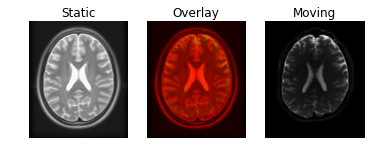

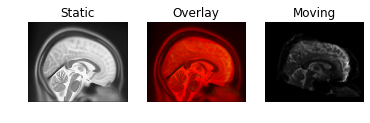

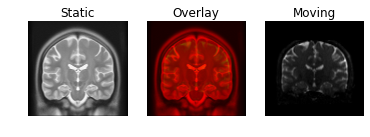

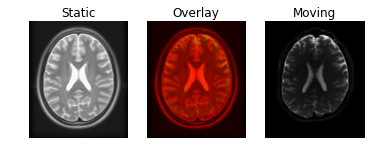

In [8]:
identity = np.eye(4)
affine_map = AffineMap(identity,
                       static.shape, static_grid2world,
                       moving.shape, moving_grid2world)
resampled = affine_map.transform(moving)
regtools.overlay_slices(static, resampled, None, 0,
                        "Static", "Moving", "resampled_0.png")
regtools.overlay_slices(static, resampled, None, 1,
                        "Static", "Moving", "resampled_1.png")
regtools.overlay_slices(static, resampled, None, 2,
                        "Static", "Moving", "resampled_2.png")

In [9]:
"""
.. figure:: resampled_0.png
   :align: center
.. figure:: resampled_1.png
   :align: center
.. figure:: resampled_2.png
   :align: center

   **Input images before alignment**.
"""

'\n.. figure:: resampled_0.png\n   :align: center\n.. figure:: resampled_1.png\n   :align: center\n.. figure:: resampled_2.png\n   :align: center\n\n   **Input images before alignment**.\n'

In [10]:
"""
We can obtain a very rough (and fast) registration by just aligning the centers
of mass of the two images
"""

'\nWe can obtain a very rough (and fast) registration by just aligning the centers\nof mass of the two images\n'

In [11]:
c_of_mass = transform_centers_of_mass(static, static_grid2world,
                                      moving, moving_grid2world)

In [12]:
"""
We can now transform the moving image and draw it on top of the static image,
registration is not likely to be good, but at least they will occupy roughly
the same space
"""

'\nWe can now transform the moving image and draw it on top of the static image,\nregistration is not likely to be good, but at least they will occupy roughly\nthe same space\n'

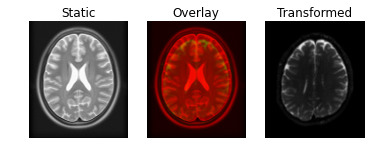

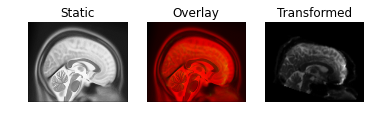

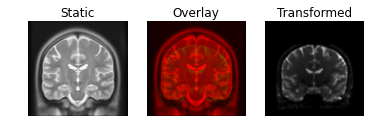

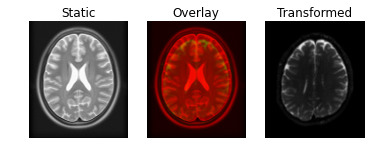

In [13]:
transformed = c_of_mass.transform(moving)
regtools.overlay_slices(static, transformed, None, 0,
                        "Static", "Transformed", "transformed_com_0.png")
regtools.overlay_slices(static, transformed, None, 1,
                        "Static", "Transformed", "transformed_com_1.png")
regtools.overlay_slices(static, transformed, None, 2,
                        "Static", "Transformed", "transformed_com_2.png")

In [14]:
"""
.. figure:: transformed_com_0.png
   :align: center
.. figure:: transformed_com_1.png
   :align: center
.. figure:: transformed_com_2.png
   :align: center

   **Registration result by aligning the centers of mass of the images**.
"""

"""
This was just a translation of the moving image towards the static image, now
we will refine it by looking for an affine transform. We first create the
similarity metric (Mutual Information) to be used. We need to specify the
number of bins to be used to discretize the joint and marginal probability
distribution functions (PDF), a typical value is 32. We also need to specify
the percentage (an integer in (0, 100]) of voxels to be used for computing the
PDFs, the most accurate registration will be obtained by using all voxels, but
it is also the most time-consuming choice. We specify full sampling by passing
None instead of an integer
"""

'\nThis was just a translation of the moving image towards the static image, now\nwe will refine it by looking for an affine transform. We first create the\nsimilarity metric (Mutual Information) to be used. We need to specify the\nnumber of bins to be used to discretize the joint and marginal probability\ndistribution functions (PDF), a typical value is 32. We also need to specify\nthe percentage (an integer in (0, 100]) of voxels to be used for computing the\nPDFs, the most accurate registration will be obtained by using all voxels, but\nit is also the most time-consuming choice. We specify full sampling by passing\nNone instead of an integer\n'

In [15]:
nbins = 32
sampling_prop = None
metric = MutualInformationMetric(nbins, sampling_prop)

In [16]:
"""
To avoid getting stuck at local optima, and to accelerate convergence, we use a
multi-resolution strategy (similar to ANTS [Avants11]_) by building a Gaussian
Pyramid. To have as much flexibility as possible, the user can specify how this
Gaussian Pyramid is built. First of all, we need to specify how many
resolutions we want to use. This is indirectly specified by just providing a
list of the number of iterations we want to perform at each resolution. Here we
will just specify 3 resolutions and a large number of iterations, 10000 at the
coarsest resolution, 1000 at the medium resolution and 100 at the finest. These
are the default settings
"""

'\nTo avoid getting stuck at local optima, and to accelerate convergence, we use a\nmulti-resolution strategy (similar to ANTS [Avants11]_) by building a Gaussian\nPyramid. To have as much flexibility as possible, the user can specify how this\nGaussian Pyramid is built. First of all, we need to specify how many\nresolutions we want to use. This is indirectly specified by just providing a\nlist of the number of iterations we want to perform at each resolution. Here we\nwill just specify 3 resolutions and a large number of iterations, 10000 at the\ncoarsest resolution, 1000 at the medium resolution and 100 at the finest. These\nare the default settings\n'

In [17]:
level_iters = [10000, 1000, 100]

In [18]:
"""
To compute the Gaussian pyramid, the original image is first smoothed at each
level of the pyramid using a Gaussian kernel with the requested sigma. A good
initial choice is [3.0, 1.0, 0.0], this is the default
"""

'\nTo compute the Gaussian pyramid, the original image is first smoothed at each\nlevel of the pyramid using a Gaussian kernel with the requested sigma. A good\ninitial choice is [3.0, 1.0, 0.0], this is the default\n'

In [19]:
sigmas = [3.0, 1.0, 0.0]

In [20]:
"""
Now we specify the sub-sampling factors. A good configuration is [4, 2, 1],
which means that, if the original image shape was (nx, ny, nz) voxels, then the
shape of the coarsest image will be about (nx//4, ny//4, nz//4), the shape in
the middle resolution will be about (nx//2, ny//2, nz//2) and the image at the
finest scale has the same size as the original image. This set of factors is
the default
"""

'\nNow we specify the sub-sampling factors. A good configuration is [4, 2, 1],\nwhich means that, if the original image shape was (nx, ny, nz) voxels, then the\nshape of the coarsest image will be about (nx//4, ny//4, nz//4), the shape in\nthe middle resolution will be about (nx//2, ny//2, nz//2) and the image at the\nfinest scale has the same size as the original image. This set of factors is\nthe default\n'

In [21]:
factors = [4, 2, 1]

In [22]:
"""
Now we go ahead and instantiate the registration class with the configuration
we just prepared
"""

'\nNow we go ahead and instantiate the registration class with the configuration\nwe just prepared\n'

In [23]:
affreg = AffineRegistration(metric=metric,
                            level_iters=level_iters,
                            sigmas=sigmas,
                            factors=factors)

In [24]:
"""
Using AffineRegistration we can register our images in as many stages as we
want, providing previous results as initialization for the next (the same logic
as in ANTS). The reason why it is useful is that registration is a non-convex
optimization problem (it may have more than one local optima), which means that
it is very important to initialize as close to the solution as possible. For
example, lets start with our (previously computed) rough transformation
aligning the centers of mass of our images, and then refine it in three stages.
First look for an optimal translation. The dictionary regtransforms contains
all available transforms, we obtain one of them by providing its name and the
dimension (either 2 or 3) of the image we are working with (since we are
aligning volumes, the dimension is 3)
"""

'\nUsing AffineRegistration we can register our images in as many stages as we\nwant, providing previous results as initialization for the next (the same logic\nas in ANTS). The reason why it is useful is that registration is a non-convex\noptimization problem (it may have more than one local optima), which means that\nit is very important to initialize as close to the solution as possible. For\nexample, lets start with our (previously computed) rough transformation\naligning the centers of mass of our images, and then refine it in three stages.\nFirst look for an optimal translation. The dictionary regtransforms contains\nall available transforms, we obtain one of them by providing its name and the\ndimension (either 2 or 3) of the image we are working with (since we are\naligning volumes, the dimension is 3)\n'

In [25]:
transform = TranslationTransform3D()
params0 = None
starting_affine = c_of_mass.affine
translation = affreg.optimize(static, moving, transform, params0,
                              static_grid2world, moving_grid2world,
                              starting_affine=starting_affine)

Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]


In [26]:
"""
If we look at the result, we can see that this translation is much better than
simply aligning the centers of mass
"""

'\nIf we look at the result, we can see that this translation is much better than\nsimply aligning the centers of mass\n'

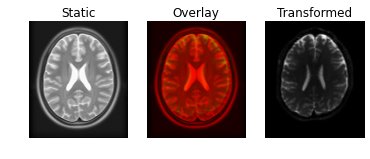

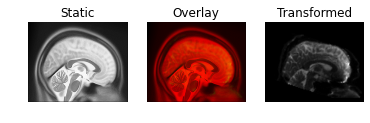

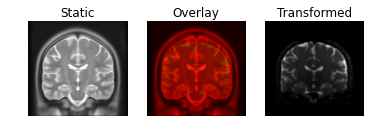

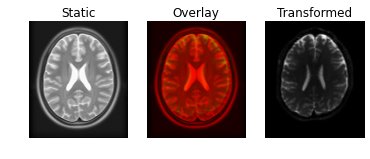

In [27]:
transformed = translation.transform(moving)
regtools.overlay_slices(static, transformed, None, 0,
                        "Static", "Transformed", "transformed_trans_0.png")
regtools.overlay_slices(static, transformed, None, 1,
                        "Static", "Transformed", "transformed_trans_1.png")
regtools.overlay_slices(static, transformed, None, 2,
                        "Static", "Transformed", "transformed_trans_2.png")

In [28]:
"""
.. figure:: transformed_trans_0.png
   :align: center
.. figure:: transformed_trans_1.png
   :align: center
.. figure:: transformed_trans_2.png
   :align: center

   **Registration result by translating the moving image, using MI**.
"""

"""
Now lets refine with a rigid transform (this may even modify our previously
found optimal translation)
"""

'\nNow lets refine with a rigid transform (this may even modify our previously\nfound optimal translation)\n'

In [29]:
transform = RigidTransform3D()
params0 = None
starting_affine = translation.affine
rigid = affreg.optimize(static, moving, transform, params0,
                        static_grid2world, moving_grid2world,
                        starting_affine=starting_affine)

Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]


In [30]:
"""
This produces a slight rotation, and the images are now better aligned
"""

'\nThis produces a slight rotation, and the images are now better aligned\n'

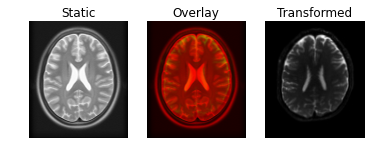

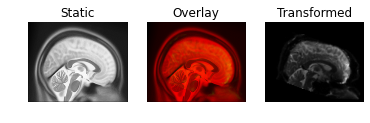

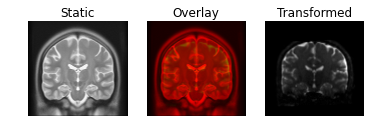

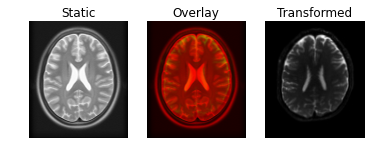

In [31]:
transformed = rigid.transform(moving)
regtools.overlay_slices(static, transformed, None, 0,
                        "Static", "Transformed", "transformed_rigid_0.png")
regtools.overlay_slices(static, transformed, None, 1,
                        "Static", "Transformed", "transformed_rigid_1.png")
regtools.overlay_slices(static, transformed, None, 2,
                        "Static", "Transformed", "transformed_rigid_2.png")

In [32]:
"""
.. figure:: transformed_rigid_0.png
   :align: center
.. figure:: transformed_rigid_1.png
   :align: center
.. figure:: transformed_rigid_2.png
   :align: center

   **Registration result with a rigid transform, using Mutual Information**.
"""

"""
Finally, lets refine with a full affine transform (translation, rotation, scale
and shear), it is safer to fit more degrees of freedom now, since we must be
very close to the optimal transform
"""

'\nFinally, lets refine with a full affine transform (translation, rotation, scale\nand shear), it is safer to fit more degrees of freedom now, since we must be\nvery close to the optimal transform\n'

In [33]:
transform = AffineTransform3D()
params0 = None
starting_affine = rigid.affine
affine = affreg.optimize(static, moving, transform, params0,
                         static_grid2world, moving_grid2world,
                         starting_affine=starting_affine)

Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]


In [34]:
"""
This results in a slight shear and scale
"""

'\nThis results in a slight shear and scale\n'

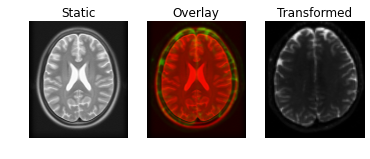

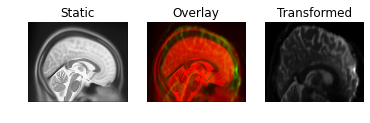

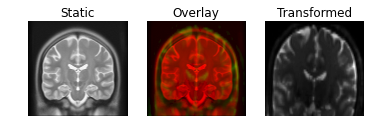

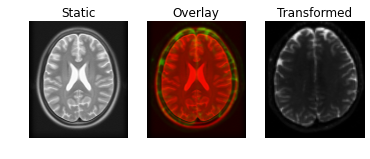

In [35]:
transformed = affine.transform(moving)
regtools.overlay_slices(static, transformed, None, 0,
                        "Static", "Transformed", "transformed_affine_0.png")
regtools.overlay_slices(static, transformed, None, 1,
                        "Static", "Transformed", "transformed_affine_1.png")
regtools.overlay_slices(static, transformed, None, 2,
                        "Static", "Transformed", "transformed_affine_2.png")

In [36]:
"""
.. figure:: transformed_affine_0.png
   :align: center
.. figure:: transformed_affine_1.png
   :align: center
.. figure:: transformed_affine_2.png
   :align: center

   **Registration result with an affine transform, using Mutual Information**.

.. [Mattes03] Mattes, D., Haynor, D. R., Vesselle, H., Lewellen, T. K.,
              Eubank, W. (2003). PET-CT image registration in the chest using
              free-form deformations. IEEE Transactions on Medical Imaging,
              22(1), 120-8.
.. [Avants11] Avants, B. B., Tustison, N., & Song, G. (2011). Advanced
              Normalization Tools ( ANTS ), 1-35.

.. include:: ../links_names.inc

"""

'\n.. figure:: transformed_affine_0.png\n   :align: center\n.. figure:: transformed_affine_1.png\n   :align: center\n.. figure:: transformed_affine_2.png\n   :align: center\n\n   **Registration result with an affine transform, using Mutual Information**.\n\n.. [Mattes03] Mattes, D., Haynor, D. R., Vesselle, H., Lewellen, T. K.,\n              Eubank, W. (2003). PET-CT image registration in the chest using\n              free-form deformations. IEEE Transactions on Medical Imaging,\n              22(1), 120-8.\n.. [Avants11] Avants, B. B., Tustison, N., & Song, G. (2011). Advanced\n              Normalization Tools ( ANTS ), 1-35.\n\n.. include:: ../links_names.inc\n\n'